<a href="https://colab.research.google.com/github/vuducanh0802/HreLanguage/blob/main/Hre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [261]:
import numpy as np
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [262]:
df = pd.read_excel('VN_Hre.xlsx',names=['Hre','VN'])
df = df.dropna()

according to observation, the text scanner often read 'o' (with a hat ^) as '8', 'l' as '1', etc. Hence we replace them

In [263]:
df['Hre'] = df['Hre'].str.replace(r'8', 'o')
df['Hre'] = df['Hre'].str.replace(r'6', 'o')
df['Hre'] = df['Hre'].str.replace(r'1', 'l')
df['Hre'] = df['Hre'].str.replace(r'9', 'q')

In [287]:
pd.DataFrame(df).sample(5)

,0,1
274,boi baiq jat,bai thu hai muoi
156,hi da eh nhin uh broq cleq oi heo heq,ngay mai chung toi khong co gi chi nghi thoi
11,heq au heq au khoi panac,cam on toi an no roi
49,in brog cleq meh,ba lam gi do
331,in q deac toq beq,anh uong nuoc nong di


In [264]:
df = np.array(df)

In [265]:
df[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in df[:,0]]
df[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in df[:,1]]
df[:5]

array([['th thai Caq poa nhoq', 'Anh an com chua'],
       ['Au khoi caq Au niu song caq', 'Toi da an roi Tai moi an xong'],
       ['in caq poa sam cleq', 'Anh an com voi gi'],
       ['Au caq sam ca Au cag sam mam heg un i caq sam cleq',
        'Toi an voi caToi an com mam thoi khong co gi khac'],
       ['Boi baig', 'Bai thu hai']], dtype=object)

In [266]:
for i in range(len(df)):
    df[i,0] = df[i,0].lower()
    df[i,1] = df[i,1].lower()

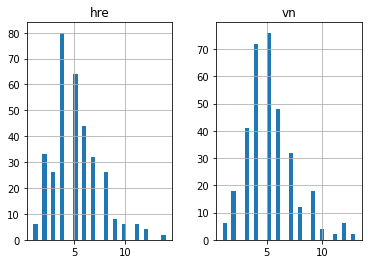

In [267]:
hre_l = []
vn_l = []

# populate the lists with sentence lengths
for i in df[:,0]:
      hre_l.append(len(i.split()))

for i in df[:,1]:
      vn_l.append(len(i.split()))

length_df = pd.DataFrame({'hre':hre_l, 'vn':vn_l})

length_df.hist(bins = 30)
plt.show()

In [268]:
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [269]:
vn_tokenizer = tokenization(df[:, 1])
vn_vocab_size = len(vn_tokenizer.word_index) + 1

vn_length = 7
print('VN Vocabulary Size: %d' % vn_vocab_size)

VN Vocabulary Size: 208


In [270]:
hre_tokenizer = tokenization(df[:, 0])
hre_vocab_size = len(hre_tokenizer.word_index) + 1

hre_length = 7
print('Hre Vocabulary Size: %d' % hre_vocab_size)

Hre Vocabulary Size: 294


In [271]:
def encode_sequences(tokenizer, length, lines):
  # integer encode sequences
  seq = tokenizer.texts_to_sequences(lines)
  # pad sequences with 0 values
  seq = pad_sequences(seq, maxlen=length, padding='post')
  return seq

In [272]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(df, test_size=0.2)

In [273]:
trainX = encode_sequences(vn_tokenizer, vn_length, train[:, 1])
trainY = encode_sequences(hre_tokenizer, hre_length, train[:, 0])

# prepare validation data
testX = encode_sequences(vn_tokenizer, vn_length, test[:, 1])
testY = encode_sequences(hre_tokenizer, hre_length, test[:, 0])

In [274]:
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [275]:
# model compilation
model = define_model(vn_vocab_size, hre_vocab_size, vn_length, hre_length, 512)

In [276]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [277]:
filename = 'model.h1.26_05_2021'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=15, batch_size=128, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=0)


Epoch 00001: val_loss improved from inf to 5.40757, saving model to model.h1.26_05_2021


INFO:tensorflow:Assets written to: model.h1.26_05_2021/assets


INFO:tensorflow:Assets written to: model.h1.26_05_2021/assets



Epoch 00002: val_loss improved from 5.40757 to 4.40443, saving model to model.h1.26_05_2021


INFO:tensorflow:Assets written to: model.h1.26_05_2021/assets


INFO:tensorflow:Assets written to: model.h1.26_05_2021/assets



Epoch 00003: val_loss improved from 4.40443 to 4.31947, saving model to model.h1.26_05_2021


INFO:tensorflow:Assets written to: model.h1.26_05_2021/assets


INFO:tensorflow:Assets written to: model.h1.26_05_2021/assets



Epoch 00004: val_loss improved from 4.31947 to 4.26493, saving model to model.h1.26_05_2021


INFO:tensorflow:Assets written to: model.h1.26_05_2021/assets


INFO:tensorflow:Assets written to: model.h1.26_05_2021/assets



Epoch 00005: val_loss did not improve from 4.26493

Epoch 00006: val_loss improved from 4.26493 to 4.26068, saving model to model.h1.26_05_2021


INFO:tensorflow:Assets written to: model.h1.26_05_2021/assets


INFO:tensorflow:Assets written to: model.h1.26_05_2021/assets



Epoch 00007: val_loss did not improve from 4.26068

Epoch 00008: val_loss did not improve from 4.26068

Epoch 00009: val_loss improved from 4.26068 to 4.24551, saving model to model.h1.26_05_2021


INFO:tensorflow:Assets written to: model.h1.26_05_2021/assets


INFO:tensorflow:Assets written to: model.h1.26_05_2021/assets



Epoch 00010: val_loss improved from 4.24551 to 4.20072, saving model to model.h1.26_05_2021


INFO:tensorflow:Assets written to: model.h1.26_05_2021/assets


INFO:tensorflow:Assets written to: model.h1.26_05_2021/assets



Epoch 00011: val_loss improved from 4.20072 to 4.09309, saving model to model.h1.26_05_2021


INFO:tensorflow:Assets written to: model.h1.26_05_2021/assets


INFO:tensorflow:Assets written to: model.h1.26_05_2021/assets



Epoch 00012: val_loss did not improve from 4.09309

Epoch 00013: val_loss did not improve from 4.09309

Epoch 00014: val_loss improved from 4.09309 to 4.06095, saving model to model.h1.26_05_2021


INFO:tensorflow:Assets written to: model.h1.26_05_2021/assets


INFO:tensorflow:Assets written to: model.h1.26_05_2021/assets



Epoch 00015: val_loss improved from 4.06095 to 4.01639, saving model to model.h1.26_05_2021


INFO:tensorflow:Assets written to: model.h1.26_05_2021/assets


INFO:tensorflow:Assets written to: model.h1.26_05_2021/assets


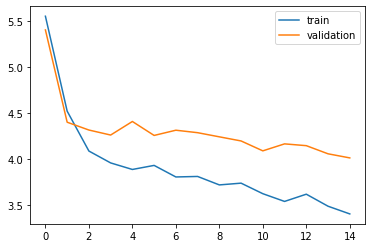

In [278]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [279]:
model = load_model('model.h1.26_05_2021')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [280]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [281]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], hre_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], hre_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [282]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [285]:
pred_df.sample(5)

,actual,predicted
58,boi noig jat baig,boi jat
27,in q deac toq beq,au
60,au un ni hag renh loq dunh,oi ta uh
47,haq lam broq viac ta cvang ngaih,au ta uh
0,dleq kh hinh caq poa,au ta


Since the dataset is too small, we cant achieve much higher score